<a href="https://colab.research.google.com/github/LCCuong/LCCuong/blob/gh-pages/Three_layers_NeuralNetwork_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib as plt
np.random.seed()

# **Tạo các activation functions**

In [ ]:

def sigmoid(s):
  return 1/(1+np.exp(-s))

def d_sigmoid(s):
  return sigmoid(s)*(1 - sigmoid(s))

print("sigmoid(s) =", sigmoid(np.asarray([3, 7, 8])))
print("d_sigmoid(s) = ", d_sigmoid(np.asarray([3, 7, 8])))

#print(np.asarray([[1, 2], [3, 4], [5, 6]]).T + np.asarray([1, 2, 3]))
#print(np.log(np.asarray([1, 2, 3])))
l = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
print(l[5:])
a = [i for i in range(5,3,-1)]
print(a)

sigmoid(s) = [0.95257413 0.99908895 0.99966465]
d_sigmoid(s) =  [0.04517666 0.00091022 0.00033524]
[6, 7, 8, 9, 10]
[5, 4]


In [ ]:
def tanh(x):
  return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

# tanh derivative
def d_tanh(x):
  return 1 - tanh(x) * tanh(x)

In [ ]:
def relu(s):
  m = 0 + s
  m[m < 0] = 0
  return m

def d_relu(s):
  m = s + 0
  m[m > 0] = 1
  return m
  
print(relu(np.asarray([3,5,-1])))
print(d_relu(np.asarray([3,5,-1])))

[3 5 0]
[ 1  1 -1]


In [ ]:
def softmax(s):
  e_s = np.exp(s - np.max(s, axis = 1, keepdims = True))
  result = e_s / e_s.sum(axis = 1, keepdims = True)
  return result

#print(softmax(np.asarray([3,5,-1])))

In [ ]:
def cross_entropy_loss(Ypred, Y): #FIX!!!
  loss = np.asarray([np.sum(np.multiply(Y[i], np.log(Ypred[i] + 1e-9))) for i in range(Y.shape[0])])
  return -np.mean(loss)

In [ ]:
class layer:
  def __init__(self, input_size, output_size, activation = "none"):
    self.input_size = input_size
    self.output_size = output_size
    if activation!="none":
      if activation == "relu":
        self.activation = relu
        self.derivative = d_relu
      elif activation == "softmax":
        self.activation = softmax
        self.derivative = 0
      elif activation == "sigmoid":
        self.activation = sigmoid
        self.derivative = d_sigmoid
      elif activation == "tanh":
        self.activation = tanh
        self.derivative = d_tanh
      else:
        raise ValueError('Activation not found')
      np.random.seed()
      self.W = np.random.randn(self.input_size, self.output_size)/np.sqrt(self.input_size*self.output_size) # *0.01 should or shouldn't???
      self.b = 1.0*np.zeros((self.output_size), dtype = np.uint8) # *0.01 should or shouldn't???
    else:
      self.activation = "none"
      if (input_size!=output_size):
        raise ValueError('Input layer must have the same input_size and output_size')
    #print(self.W.type)
  def __call__(self, input):
    if self.activation != "none":
      self.z = np.dot(input, self.W) + self.b
      #self.z = self.W.T.dot(input) + self.b
      self.a = self.activation(self.z)
      return self.a
    else:
      self.a = self.z = input
      return input

In [ ]:
import math
import random
print(math.ceil(2.8))

3


# **3_layers_Network**

In [ ]:
class Neural_network:
  def __init__(self, *args):
    self.Number_Of_Layers = len(args)
    self.L = []
    #if len(args)!=3:
     # raise ValueError(f'Number of layers must be 3')
    for arg in args:
      if len(self.L)!=0:
        if arg.input_size != self.L[len(self.L)-1].output_size:
          raise ValueError(f'input_size of layer {len(self.L)} must equal to output_size of layer {len(self.L)-1}')
      self.L.append(arg)
##########################################################################################################################
  def FeedForward(self, input):
    x = input
    #print(x.shape)
    for Layer in self.L:
      x = Layer(x)
    return x
##########################################################################################################################
  def Backpropagation(self, X, Y):
    E = (self.L[self.Number_Of_Layers - 1].a - Y)/(self.L[self.Number_Of_Layers - 1].a.shape[0])
    #print("hello:", self.L[self.Number_Of_Layers - 2].a.shape[0])
    delta_W = []
    d_W = np.dot(self.L[self.Number_Of_Layers - 2].a.T, E)
    delta_W.append(d_W)
    delta_b = []
    d_b = np.sum(E, axis = 0)
    delta_b.append(d_b)
    for i in range(self.Number_Of_Layers-2, 0, -1):
      E = np.multiply(np.dot(E, self.L[i+1].W.T), self.L[i].derivative(self.L[i].z))
      d_W = np.dot(self.L[i-1].a.T, E)
      delta_W.insert(0,d_W)
      d_b = np.sum(E, axis = 0)
      delta_b.insert(0, d_b)

    return delta_W, delta_b
##########################################################################################################################
  def lr_exp_decay(self, epoch, init_eta):
      k = 0.1
      return init_eta * math.exp(-k*epoch)
##########################################################################################################################
  def val(self, pred, truth):
    pred_result = np.asarray([pred[i].argmax() for i in range(len(pred))])
    truth_result = np.asarray([truth[i].argmax() for i in range(len(truth))])
    return np.mean(pred_result == truth_result)
#########################################################################################################################
  def predict(self, X):
    pred = self.FeedForward(X)
    return pred
##########################################################################################################################
  def fit(self, X, Y, epoches, eta, batch_size):
    numberOfBatch = math.ceil(X.shape[0]/batch_size)
    loss_array = []
    lenLoss = 0
    random.seed()
    self.val_array = []
    self.acc_array = []
    LR = eta
    for epoch in range(epoches):
      loss = 0
     # if (epoch+1)%10 == 0:
      LR = self.lr_exp_decay(epoch, eta)
      val_array = []
      acc_array = []
      for batch in range(numberOfBatch-1):
        TrainX = X[batch*batch_size : (batch+1)*batch_size - 1]
        TrainY = Y[batch*batch_size : (batch+1)*batch_size - 1]
        TestX = X[(numberOfBatch - 1)*batch_size : ]
        TestY = Y[(numberOfBatch - 1)*batch_size : ]
        test_result = self.predict(TestX)
        val_array.append(self.val(test_result, TestY))
        ypred = self.FeedForward(TrainX)
        acc_array.append(self.val(ypred, TrainY))
        loss = cross_entropy_loss(ypred, TrainY)
          #print(ypred[0][5], ypred[0].argmax())
        (dW, db) = self.Backpropagation(TrainX, TrainY)
        for i in range(1, self.Number_Of_Layers):
          self.L[i].W += -LR*dW[i-1]
          self.L[i].b += -LR*db[i-1]
      val_acc = np.mean(np.asarray(val_array))
      acc = np.mean(np.asarray(acc_array))
      self.val_array.append(val_acc)
      self.acc_array.append(acc)
      print(f"epoch {epoch} - loss: {loss} - val_acc: {val_acc} - acc: {acc} - learning rate: {LR}")
      dist = abs(val_acc - acc)
      #if dist < 0.001 and epoch>=50:
       # return
##########################################################################################################################


In [ ]:
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [ ]:
def to_one_hot(labels, dimension):
  result =np.zeros((len(labels), dimension), dtype = np.uint8)
  for i, label in enumerate(labels):
    result[i, label] = 1
  return np.asarray(result)
  

In [ ]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))
train_X[train_X>0] = 1
test_X[test_X>0] = 1
train_size = train_X.shape[0]
test_size = test_X.shape[0]
#-----------------------------------------------------------------------
trainX = np.asarray([train_X[i].flatten() for i in range(train_size)])
testX = np.asarray([test_X[i].flatten() for i in range(test_size)])
#-----------------------------------------------------------------------
trainY = to_one_hot(train_y, 10)
testY = to_one_hot(test_y, 10)
print(trainY.shape)

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)
(60000, 10)


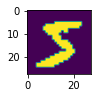

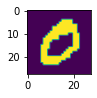

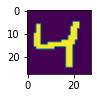

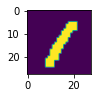

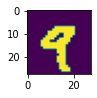

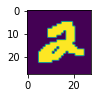

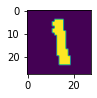

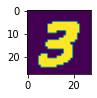

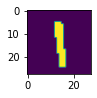

In [ ]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
for i in range(9):  
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(train_X[i])#, cmap=pyplot.get_cmap('gray'))
  pyplot.show()

In [ ]:
model = Neural_network(
    layer(input_size = 28*28, output_size = 28*28),
    layer(input_size = 28*28, output_size = 1024, activation = "relu"),
    #layer(input_size = 1024, output_size = 1024, activation = "relu"),
    #layer(input_size = 1024, output_size = 1024, activation  = "relu"),
    layer(input_size = 1024, output_size = 10, activation = "softmax")
)
Num_epoches = 20
model.fit(trainX, trainY, epoches = Num_epoches, eta = 0.5, batch_size = 512)

epoch 0 - loss: 0.22060508615001997 - val_acc: 0.8141025641025641 - acc: 0.7952063157542609 - learning rate: 0.5
epoch 1 - loss: 0.1669778265741686 - val_acc: 0.9602920227920227 - acc: 0.930101861608711 - learning rate: 0.45241870901797976
epoch 2 - loss: 0.14613159156205052 - val_acc: 0.9859330484330483 - acc: 0.9478649204676602 - learning rate: 0.4093653765389909
epoch 3 - loss: 0.13394133886592288 - val_acc: 0.9885149572649573 - acc: 0.9571980530884638 - learning rate: 0.37040911034085894
epoch 4 - loss: 0.12580950146742204 - val_acc: 0.989227207977208 - acc: 0.9624500309431815 - learning rate: 0.33516002301781966
epoch 5 - loss: 0.11907344065028376 - val_acc: 0.989494301994302 - acc: 0.9665646377975144 - learning rate: 0.3032653298563167
epoch 6 - loss: 0.11301658535597975 - val_acc: 0.9895833333333334 - acc: 0.9690568183718867 - learning rate: 0.2744058180470132
epoch 7 - loss: 0.10822743443757515 - val_acc: 0.9895833333333334 - acc: 0.9710806697108068 - learning rate: 0.248292651

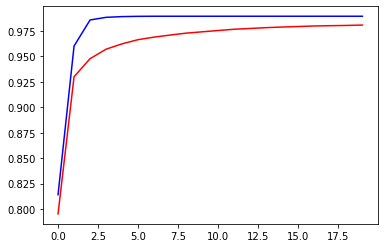

In [ ]:
acc_list = model.acc_array
val_acc_list = model.val_array
plt.plot(range(Num_epoches), acc_list, color = "red", label = "Training accuracy")
plt.plot(range(Num_epoches), val_acc_list, color = "blue", label = "Training val_accuracy")

In [ ]:
test = model.predict(testX)
print(test.shape)

(10000, 10)


In [ ]:
test_result = np.asarray([test[i].argmax() for i in range(len(test))])

In [ ]:
print(test_result)
print(test_y)

[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]


In [ ]:
acc = np.mean(test_result == test_y)

In [ ]:
print(acc)

0.9739


In [ ]:
"""
import cv2
from google.colab.patches import cv2_imshow
"""

'\nimport cv2\nfrom google.colab.patches import cv2_imshow\n'

In [ ]:
""""
image = cv2.imread("/content/7.2.png")
cv2_i
"""

'"\nimage = cv2.imread("/content/7.2.png")\ncv2_i\n'

In [ ]:
#imageB2G = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
#imageB2G

In [ ]:
#img = np.asarray(imageB2G)
#img[img>0] = 1

In [ ]:
#imgArray = [img.flatten()]

In [ ]:
#imgArray

In [ ]:
""""
PRED = model.predict(imgArray)
print("Image: ")
cv2_imshow(image)
print("Prediction result: ", np.asarray(PRED).argmax())
"""

'"\nPRED = model.predict(imgArray)\nprint("Image: ")\ncv2_imshow(image)\nprint("Prediction result: ", np.asarray(PRED).argmax())\n'